In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as vale
import seaborn as sns
from sklearn import linear_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


In [2]:
calendario= pd.read_csv("calendar.csv")
cat_art=pd.read_csv("Datos_limpios/cat_articulos.csv",index_col=0)
cat_st=pd.read_csv("Datos_limpios/cat_tiendas.csv",index_col=0)
ventas_trans= pd.read_csv("Datos_limpios/ventas_transacc.csv",index_col=0)
submision=pd.read_csv("sample_submission.csv")
precio_venta=pd.read_csv("sell_prices.csv")



/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Realiza una clasificación de los productos. ¿Cuáles son los productos más caros, regulares, y menos caros que maneja la empresa?

In [3]:
promedio_precio= precio_venta.groupby(["item_id"])["sell_price"].median().reset_index()
print(promedio_precio["sell_price"].min())
lim_barato= np.quantile(promedio_precio["sell_price"],.25)
print(promedio_precio["sell_price"].median())
lim_regular= np.quantile(promedio_precio["sell_price"],.75)
print(promedio_precio["sell_price"].max())
#print(promedio_precio)

0.2
3.42
29.97


In [4]:
## Maneja el precio promedio por producto a través del tiempo. Utiliza los precios hasta el primer cuartil como los productos baratos, del primer cuartil al tercer cuartil como los productos de precio regular, y los productos después del tercer cuartil como los productos caros.

promedio_precio["categoria_precio"]=""
promedio_precio["categoria_precio"]=np.where(promedio_precio["sell_price"]<= lim_barato,"barato","regular")
promedio_precio["categoria_precio"]=np.where(promedio_precio["sell_price"]> lim_regular,"caro",promedio_precio["categoria_precio"])
print(promedio_precio)

              item_id  sell_price categoria_precio
0         FOODS_1_001        2.24           barato
1         FOODS_1_002        8.88             caro
2         FOODS_1_003        2.88          regular
3         FOODS_1_004        1.78           barato
4         FOODS_1_005        3.28          regular
...               ...         ...              ...
3044  HOUSEHOLD_2_512        3.97          regular
3045  HOUSEHOLD_2_513        2.78          regular
3046  HOUSEHOLD_2_514       18.97             caro
3047  HOUSEHOLD_2_515        1.97           barato
3048  HOUSEHOLD_2_516        5.94             caro

[3049 rows x 3 columns]


Agrupa las ventas a nivel nacional de acuerdo a la clasificación de precios. ¿Cómo se comporta la venta promedio por producto a través del tiempo para cada clasificación? ¿Los productos más caros se venden menos que las más baratas?

In [5]:
#print(ventas_trans)
venta_suma= ventas_trans.groupby([ "d","num_item_id"])["sales"].sum().reset_index()

print(cat_art)

            item_id    dept_id   cat_id  num_item_id
0     HOBBIES_1_001  HOBBIES_1  HOBBIES            1
1     HOBBIES_1_002  HOBBIES_1  HOBBIES            2
2     HOBBIES_1_003  HOBBIES_1  HOBBIES            3
3     HOBBIES_1_004  HOBBIES_1  HOBBIES            4
4     HOBBIES_1_005  HOBBIES_1  HOBBIES            5
...             ...        ...      ...          ...
3044    FOODS_3_823    FOODS_3    FOODS         3045
3045    FOODS_3_824    FOODS_3    FOODS         3046
3046    FOODS_3_825    FOODS_3    FOODS         3047
3047    FOODS_3_826    FOODS_3    FOODS         3048
3048    FOODS_3_827    FOODS_3    FOODS         3049

[3049 rows x 4 columns]


In [6]:
precio_mean=precio_venta.groupby(["item_id","wm_yr_wk"])["sell_price"].mean().reset_index()
precio_mean=precio_mean.merge(cat_art[["num_item_id","item_id"]],on="item_id")
precio_mean=precio_mean.merge(calendario[["date","wm_yr_wk","d"]],on="wm_yr_wk")
ventaprecio_suma=precio_mean[["item_id","num_item_id","d","date","sell_price"]].merge(venta_suma,on=["num_item_id","d"])
ventaprecio_suma=ventaprecio_suma.merge(promedio_precio[["item_id","categoria_precio"]],on="item_id")
ventaprecio_mean=ventaprecio_suma.groupby(["date","categoria_precio"])[["sales","sell_price"]].mean().reset_index()
print(ventaprecio_mean)

            date categoria_precio      sales  sell_price
0     2011-01-29           barato  48.613139    1.452611
1     2011-01-29             caro   8.011236    8.554052
2     2011-01-29          regular  14.201449    3.542650
3     2011-01-30           barato  47.201946    1.452611
4     2011-01-30             caro   7.415730    8.554052
...          ...              ...        ...         ...
5734  2016-04-23             caro   7.960159    9.243827
5735  2016-04-23          regular  13.213811    3.672485
5736  2016-04-24           barato  28.196203    1.488673
5737  2016-04-24             caro   8.586985    9.243827
5738  2016-04-24          regular  13.980080    3.672485

[5739 rows x 4 columns]


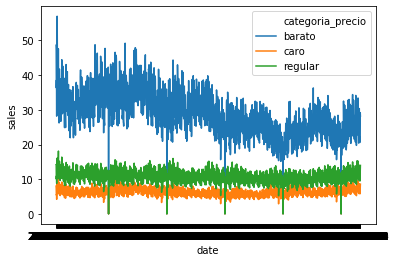

In [7]:
sns.lineplot(x="date",y="sales", data= ventaprecio_mean, hue="categoria_precio")



# ¿Existe una diferencia significativa entre la venta promedio por tienda por Estado? Realiza un ANOVA bifactorial (donde se consideren como factores el Estado y el Año) para responder a este cuestionamiento. Utiliza un nivel de significancia de 0.05.

In [8]:
#print(ventas_trans)
#print(calendario)
#print(cat_st)

datos_general= ventas_trans[["num_store","d","sales"]].merge(calendario[["d","year"]],on="d")
datos_general=datos_general.merge(cat_st,on="num_store")
datos_anual= datos_general.groupby(["year","store_id","state_id"])["sales"].sum().reset_index()
print(datos_anual)

ventas_lm=ols("sales ~ C(state_id)+ C(year)", data=datos_anual).fit()
anova_table=sm.stats.anova_lm(ventas_lm,typ=2)
print(anova_table)

    year store_id state_id    sales
0   2011     CA_1       CA  1060793
1   2011     CA_2       CA   826083
2   2011     CA_3       CA  1520827
3   2011     CA_4       CA   536099
4   2011     TX_1       TX   799556
5   2011     TX_2       TX  1060623
6   2011     TX_3       TX   850980
7   2011     WI_1       WI   540021
8   2011     WI_2       WI   566254
9   2011     WI_3       WI  1095349
10  2012     CA_1       CA  1406432
11  2012     CA_2       CA  1032484
12  2012     CA_3       CA  2099706
13  2012     CA_4       CA   729865
14  2012     TX_1       TX  1064111
15  2012     TX_2       TX  1460222
16  2012     TX_3       TX  1087198
17  2012     WI_1       WI   725388
18  2012     WI_2       WI  1018731
19  2012     WI_3       WI  1437700
20  2013     CA_1       CA  1538540
21  2013     CA_2       CA  1121532
22  2013     CA_3       CA  2249633
23  2013     CA_4       CA   824096
24  2013     TX_1       TX  1105570
25  2013     TX_2       TX  1536308
26  2013     TX_3       TX  

In [9]:
datos_estado=datos_anual.groupby(["store_id","state_id"]).mean().reset_index()
ventas_lm=ols("sales ~ C(state_id)", data=datos_estado).fit()
anova_table=sm.stats.anova_lm(ventas_lm,typ=2)
print(anova_table)
print(datos_estado)

                   sum_sq   df         F    PR(>F)
C(state_id)  6.932470e+10  2.0  0.285397  0.760061
Residual     8.501723e+11  7.0       NaN       NaN
  store_id state_id    year         sales
0     CA_1       CA  2013.5  1.283036e+06
1     CA_2       CA  2013.5  9.475792e+05
2     CA_3       CA  2013.5  1.864697e+06
3     CA_4       CA  2013.5  6.839460e+05
4     TX_1       TX  2013.5  9.325487e+05
5     TX_2       TX  2013.5  1.202397e+06
6     TX_3       TX  2013.5  1.014888e+06
7     WI_1       WI  2013.5  8.581770e+05
8     WI_2       WI  2013.5  1.090669e+06
9     WI_3       WI  2013.5  1.071297e+06


# Agrupa los datos de venta a nivel nacional y por categoría, y contesta las siguientes preguntas relacionadas con el tema de estacionalidad:

In [10]:
#print(cat_art)
#print(ventas_trans)
#print(calendario)

agrupado_nacional=cat_art[["cat_id","num_item_id"]].merge(ventas_trans[["num_item_id","d","sales"]],on="num_item_id")
agrupado_nacional=agrupado_nacional.groupby(["cat_id","d"])["sales"].sum().reset_index()
agrupado_nacional=agrupado_nacional.merge(calendario,on="d")

print(agrupado_nacional)

         cat_id      d  sales        date  wm_yr_wk    weekday  wday  month  \
0         FOODS    d_1  23178  2011-01-29     11101   Saturday     1      1   
1       HOBBIES    d_1   3764  2011-01-29     11101   Saturday     1      1   
2     HOUSEHOLD    d_1   5689  2011-01-29     11101   Saturday     1      1   
3         FOODS   d_10  18901  2011-02-07     11102     Monday     3      2   
4       HOBBIES   d_10   2615  2011-02-07     11102     Monday     3      2   
...         ...    ...    ...         ...       ...        ...   ...    ...   
5734    HOBBIES  d_998   3236  2013-10-22     11339    Tuesday     4     10   
5735  HOUSEHOLD  d_998   6592  2013-10-22     11339    Tuesday     4     10   
5736      FOODS  d_999  19365  2013-10-23     11339  Wednesday     5     10   
5737    HOBBIES  d_999   3572  2013-10-23     11339  Wednesday     5     10   
5738  HOUSEHOLD  d_999   6588  2013-10-23     11339  Wednesday     5     10   

      year event_name_1 event_type_1 event_name_2 e

¿Existe algún efecto del día de la semana en la venta promedio percibida? Revisa el comportamiento de ventas por día de la semana (eliminando aquellas semanas que contengan algún día festivo). ¿Varía por categoría?

In [11]:
semana_festivas=calendario[~calendario["event_name_1"].isna()]["wm_yr_wk"]
agrupado_dia=agrupado_nacional[~agrupado_nacional["wm_yr_wk"].isin(semana_festivas)]
weekday=agrupado_dia.groupby(["cat_id","weekday"])["sales"].mean().reset_index()
dia_general=agrupado_dia.groupby("cat_id")["sales"].mean().reset_index(name="sales_general")
day_mean= weekday.merge(dia_general,on="cat_id")
day_mean["incremento"]= day_mean["sales"]/day_mean["sales_general"]
#print(weekday)
print(day_mean)

       cat_id    weekday         sales  sales_general  incremento
0       FOODS     Friday  23731.223776   23702.499501    1.001212
1       FOODS     Monday  22429.524476   23702.499501    0.946294
2       FOODS   Saturday  28132.680556   23702.499501    1.186908
3       FOODS     Sunday  29094.229167   23702.499501    1.227475
4       FOODS   Thursday  21032.034965   23702.499501    0.887334
5       FOODS    Tuesday  20884.559441   23702.499501    0.881112
6       FOODS  Wednesday  20544.559441   23702.499501    0.866768
7     HOBBIES     Friday   3378.678322    3221.848455    1.048677
8     HOBBIES     Monday   2949.552448    3221.848455    0.915485
9     HOBBIES   Saturday   3927.680556    3221.848455    1.219077
10    HOBBIES     Sunday   3654.333333    3221.848455    1.134235
11    HOBBIES   Thursday   2929.447552    3221.848455    0.909244
12    HOBBIES    Tuesday   2840.104895    3221.848455    0.881514
13    HOBBIES  Wednesday   2865.181818    3221.848455    0.889298
14  HOUSEH

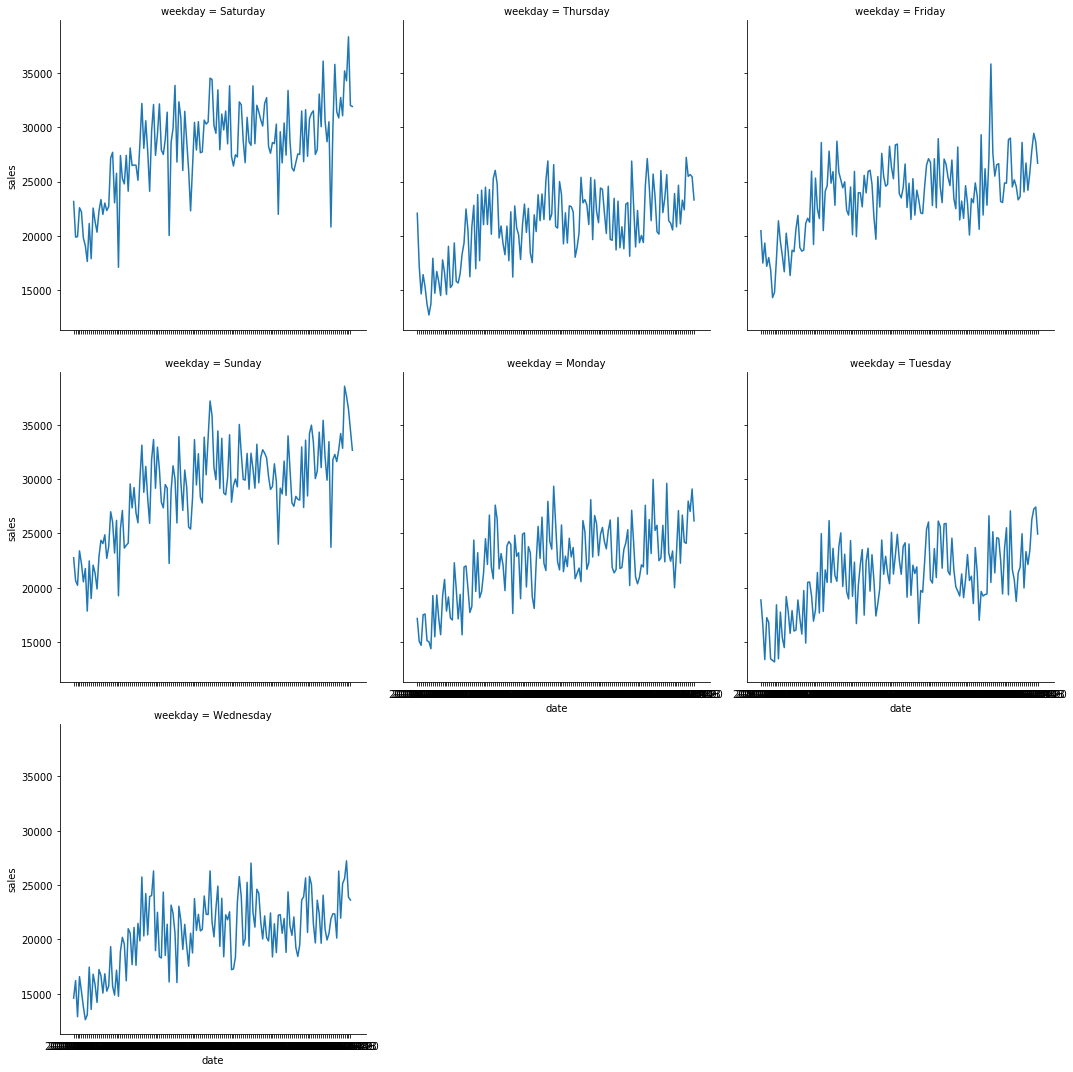

In [12]:
sns.relplot(x="date",y="sales",col="weekday",col_wrap=3,data=agrupado_dia[agrupado_dia["cat_id"]=="FOODS"],kind="line")

In [13]:
agrupado_semana=agrupado_dia.groupby(["cat_id","wm_yr_wk"])["sales"].mean().reset_index(name="sales_week")
semana_comparasion= agrupado_dia[["cat_id","wm_yr_wk","weekday","sales"]].merge(agrupado_semana,on=["cat_id","wm_yr_wk"])
semana_comparasion["incremento"]= semana_comparasion["sales"]/semana_comparasion["sales_week"]
print(semana_comparasion)

         cat_id  wm_yr_wk    weekday  sales    sales_week  incremento
0         FOODS     11101   Saturday  23178  19882.000000    1.165778
1         FOODS     11101     Sunday  22758  19882.000000    1.144653
2         FOODS     11101     Monday  17174  19882.000000    0.863796
3         FOODS     11101    Tuesday  18878  19882.000000    0.949502
4         FOODS     11101  Wednesday  14603  19882.000000    0.734483
...         ...       ...        ...    ...           ...         ...
3004  HOUSEHOLD     11337     Monday   7964   8466.857143    0.940609
3005  HOUSEHOLD     11337    Tuesday   7095   8466.857143    0.837973
3006  HOUSEHOLD     11337  Wednesday   6809   8466.857143    0.804195
3007  HOUSEHOLD     11337   Thursday   6854   8466.857143    0.809509
3008  HOUSEHOLD     11337     Friday   7971   8466.857143    0.941436

[3009 rows x 6 columns]


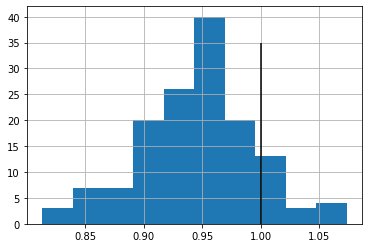

In [14]:
semana_comparasion[(semana_comparasion["cat_id"]=="FOODS") & (semana_comparasion["weekday"]=="Monday")]["incremento"].hist()
plt.vlines(x=1,ymin=0,ymax=35)

In [15]:
semana_lunes=semana_comparasion[(semana_comparasion["cat_id"]=="FOODS") & (semana_comparasion["weekday"]=="Sunday")]
vale.ttest_1samp(semana_lunes["incremento"],popmean=1.0)
#print(semana_lunes)

Ttest_1sampResult(statistic=40.60427966579497, pvalue=2.183950884040395e-80)

In [16]:
dias_semana= semana_comparasion["weekday"].unique()
cat_diversas= semana_comparasion["cat_id"].unique()
efecto_dia=pd.DataFrame()
for dia in dias_semana:
    for categoria in cat_diversas:
        categoria_dia= semana_comparasion[(semana_comparasion["cat_id"]==categoria)& (semana_comparasion["weekday"]==dia)]
        promedio= categoria_dia["incremento"].mean()
        desv=categoria_dia["incremento"].std()
        numero=len(categoria_dia)
        error= desv/(numero**.5)
        prueba= vale.ttest_1samp(categoria_dia["incremento"],popmean=1.0)
        diccionario= {"categoria":categoria,"dia":dia,"promedio":promedio,"desv":desv,"muestra": numero, "error":error,"estadistico":prueba[0],"valorp":prueba[1]}
        
        efecto_dia= efecto_dia.append(pd.DataFrame(pd.Series(diccionario)).T)
        
        
        print(categoria_dia)
        
print(efecto_dia)

     cat_id  wm_yr_wk   weekday  sales    sales_week  incremento
0     FOODS     11101  Saturday  23178  19882.000000    1.165778
23    FOODS     11339  Saturday  27938  22708.000000    1.230315
42    FOODS     11341  Saturday  31225  26101.428571    1.196295
63    FOODS     11343  Saturday  29763  22719.000000    1.310049
84    FOODS     11346  Saturday  31504  25290.000000    1.245710
...     ...       ...       ...    ...           ...         ...
2904  FOODS     11333  Saturday  34533  29618.142857    1.165941
2925  FOODS     11334  Saturday  34404  26432.428571    1.301583
2946  FOODS     11335  Saturday  30161  24190.285714    1.246823
2967  FOODS     11336  Saturday  29453  25305.428571    1.163900
2988  FOODS     11337  Saturday  33455  27593.857143    1.212408

[144 rows x 6 columns]
       cat_id  wm_yr_wk   weekday  sales   sales_week  incremento
7     HOBBIES     11101  Saturday   3764  2921.428571    1.288411
30    HOBBIES     11339  Saturday   4242  3575.857143    1.18628

¿Existe efecto de estacionalidad por mes en la venta promedio percibida? Agrupa las ventas a nivel mensual y explora esta cuestión. ¿Varía por categoría?

     year  month     cat_id   sales       tiempo
3    2011      2      FOODS  520250  2011.083333
4    2011      2    HOBBIES   77362  2011.083333
5    2011      2  HOUSEHOLD  128763  2011.083333
6    2011      3      FOODS  534914  2011.166667
7    2011      3    HOBBIES   83691  2011.166667
..    ...    ...        ...     ...          ...
184  2016      2    HOBBIES  112939  2016.083333
185  2016      2  HOUSEHOLD  295249  2016.083333
186  2016      3      FOODS  855454  2016.166667
187  2016      3    HOBBIES  116241  2016.166667
188  2016      3  HOUSEHOLD  304051  2016.166667

[186 rows x 5 columns]


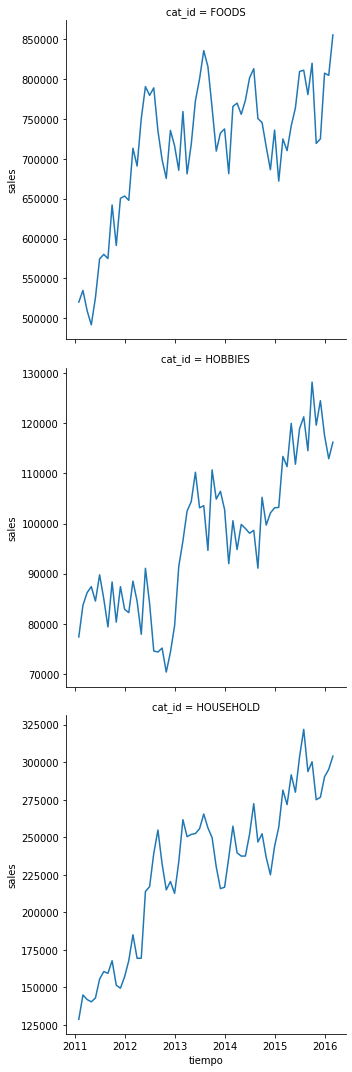

In [17]:

agrupado_mes= agrupado_nacional.groupby(["year","month","cat_id"])["sales"].sum().reset_index()
agrupado_mes["tiempo"]= agrupado_mes["year"]+(agrupado_mes["month"]-1)/12
agrupado_mes=agrupado_mes[ ~((agrupado_mes["year"]==2011) & (agrupado_mes["month"]==1))]
agrupado_mes=agrupado_mes[ ~((agrupado_mes["year"]==2016) & (agrupado_mes["month"]==4))]
sns.relplot(x="tiempo",y="sales",row="cat_id",data=agrupado_mes,facet_kws={"sharey":False},kind="line")
print(agrupado_mes)

        cat_id  year  month  item_id       tiempo
0        FOODS  2011      1      714  2011.000000
1        FOODS  2011      2      758  2011.083333
2        FOODS  2011      3      778  2011.166667
3        FOODS  2011      4      811  2011.250000
4        FOODS  2011      5      824  2011.333333
..         ...   ...    ...      ...          ...
193  HOUSEHOLD  2016      2     1047  2016.083333
194  HOUSEHOLD  2016      3     1047  2016.166667
195  HOUSEHOLD  2016      4     1047  2016.250000
196  HOUSEHOLD  2016      5     1047  2016.333333
197  HOUSEHOLD  2016      6     1047  2016.416667

[198 rows x 5 columns]


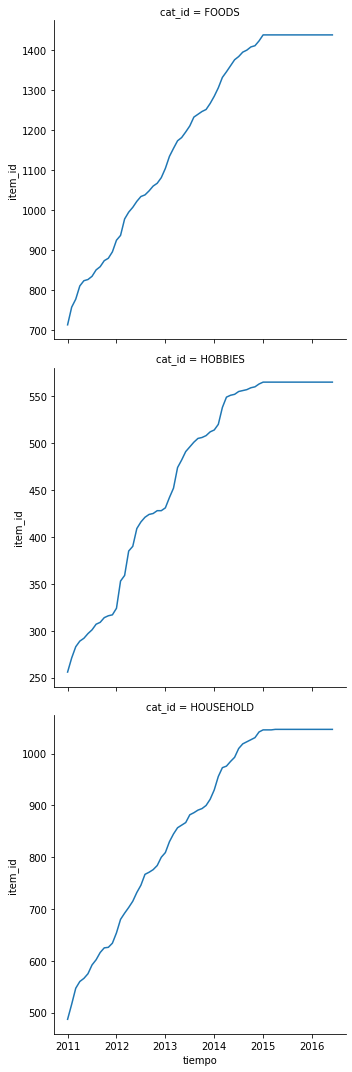

In [18]:

articulos_tiempo=precio_venta.merge(cat_art,on= "item_id")
articulos_tiempo= articulos_tiempo.merge(calendario[["month","year","wm_yr_wk"]],on="wm_yr_wk")
categoria_articulos= articulos_tiempo.groupby(["cat_id","year","month"])["item_id"].nunique().reset_index()
categoria_articulos["tiempo"]=categoria_articulos["year"]+(categoria_articulos["month"]-1)/12
sns.relplot(x="tiempo",y="item_id",row="cat_id",data=categoria_articulos,facet_kws={"sharey":False},kind="line")
print(categoria_articulos)

,year,month,cat_id,sales,tiempo,sales_mean,incremento,month_str
0,2011,2,FOODS,520250,2011.083333,563250.363636,0.923657,2
1,2011,3,FOODS,534914,2011.166667,563250.363636,0.949691,3
2,2011,4,FOODS,509568,2011.250000,563250.363636,0.904692,4
3,2011,5,FOODS,491753,2011.333333,563250.363636,0.873063,5
4,2011,6,FOODS,525861,2011.416667,563250.363636,0.933619,6
...,...,...,...,...,...,...,...,...
181,2016,2,HOBBIES,112939,2016.083333,115577.666667,0.977170,2
182,2016,3,HOBBIES,116241,2016.166667,115577.666667,1.005739,3
183,2016,1,HOUSEHOLD,290293,2016.000000,296531.000000,0.978963,1
184,2016,2,HOUSEHOLD,295249,2016.083333,296531.000000,0.995677,2


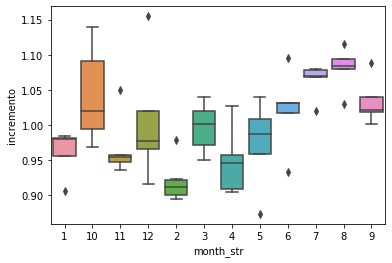

In [19]:
#print(agrupado_mes)
agrupado_año= agrupado_mes.groupby(["cat_id","year"])["sales"].mean().reset_index(name="sales_mean")
agrupado_general= agrupado_mes.merge(agrupado_año,on=["cat_id","year"])
agrupado_general["incremento"]= agrupado_general["sales"]/agrupado_general["sales_mean"]
agrupado_general["month_str"]=agrupado_general["month"].astype(str)


sns.boxplot(x="month_str", y="incremento", data=agrupado_general[agrupado_general["cat_id"]=="FOODS"])

agrupado_general

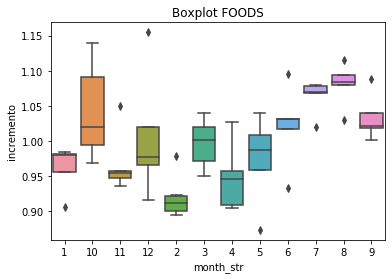

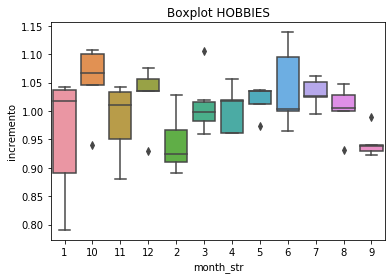

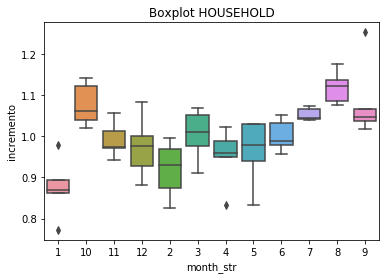

In [20]:
#meses= agrupado_general["month_str"].unique()
categorias= semana_comparasion["cat_id"].unique()

for categoria in categorias:
    sns.boxplot(x="month_str", y="incremento", data=agrupado_general[agrupado_general["cat_id"]==categoria]).set_title("Boxplot "+ categoria)
    plt.show()
    

In [21]:
efecto_mes= pd.DataFrame()
for mes in range(1,13):
    for categoria in categorias:
        categoria_mes= agrupado_general[(agrupado_general["cat_id"]==categoria)& (agrupado_general["month"]==mes)]
        promedio=categoria_mes["incremento"].mean()
        desv=categoria_mes["incremento"].std()
        numero=len(categoria_mes)
        error= desv/(numero**.5)
        prueba= vale.ttest_1samp(categoria_mes["incremento"],popmean=1.0)
        diccionario= {"categoria":categoria,"mes":mes,"promedio":promedio,"desv":desv,"muestra": numero, "error":error,"estadistico":prueba[0],"valorp":prueba[1]}
        #print(prueba)
        efecto_mes= efecto_mes.append(pd.DataFrame(pd.Series(diccionario)).T)
print(efecto_mes)


   categoria mes  promedio       desv muestra       error estadistico  \
0      FOODS   1  0.961313  0.0332652       5   0.0148767    -2.60054   
0    HOBBIES   1  0.955293   0.110943       5   0.0496154   -0.901074   
0  HOUSEHOLD   1  0.875151  0.0740411       5   0.0331122    -3.77048   
0      FOODS   2  0.919721  0.0306743       6   0.0125227    -6.41067   
0    HOBBIES   2  0.942046  0.0512802       6   0.0209351    -2.76826   
0  HOUSEHOLD   2   0.91981  0.0671622       6   0.0274188    -2.92464   
0      FOODS   3  0.996341  0.0347787       6   0.0141984   -0.257734   
0    HOBBIES   3      1.01  0.0517232       6   0.0211159    0.473617   
0  HOUSEHOLD   3   1.00505  0.0603301       6   0.0246297    0.205051   
0      FOODS   4  0.948745  0.0492853       5   0.0220411    -2.32545   
0    HOBBIES   4   1.00345  0.0414549       5   0.0185392    0.185971   
0  HOUSEHOLD   4  0.950831  0.0720287       5   0.0322122    -1.52641   
0      FOODS   5  0.973364  0.0634184       5   0.0

# ¿Las fechas festivas como tal generan un incremento notable en las ventas? ¿Varía por categoría?

In [22]:
calendario_puente=calendario[(~calendario["event_name_1"].isna())]
calendario_puente=calendario_puente[["d","event_name_1","event_type_1","event_name_2","event_type_2","wm_yr_wk"]].merge(ventas_trans[["d","sales"]],on="d")
calendario_puente=calendario_puente.fillna("NA")
calendario_puente=calendario_puente.groupby(["d","event_name_1","event_type_1","event_name_2","event_type_2","wm_yr_wk"]).sum().reset_index()
#print(calendario_puente[(calendario_puente["event_name_1"]=="Father's day") | (calendario_puente["event_name_2"]=="Father's day")])
print(calendario_puente)

          d   event_name_1 event_type_1 event_name_2 event_type_2  wm_yr_wk  \
0     d_100   Mother's day     Cultural           NA           NA     11115   
1    d_1007      Halloween     Cultural           NA           NA     11340   
2    d_1018    VeteransDay     National           NA           NA     11342   
3    d_1035   Thanksgiving     National           NA           NA     11344   
4    d_1042   Chanukah End    Religious           NA           NA     11345   
..      ...            ...          ...          ...          ...       ...   
149   d_923    Eid al-Fitr    Religious           NA           NA     11328   
150   d_948       LaborDay     National           NA           NA     11332   
151    d_97  Cinco De Mayo     Cultural           NA           NA     11114   
152   d_990    ColumbusDay     National           NA           NA     11338   
153   d_991      EidAlAdha    Religious           NA           NA     11338   

     sales  
0    23688  
1    27034  
2    36396  

In [23]:
event_name=[]
event_type=[]
d=[]
wm_yr_wk=[]


for index, row in calendario_puente.iterrows():
    
    event_name.append(row["event_name_1"])
    event_type.append(row["event_type_1"])
    d.append(row["d"])
    wm_yr_wk.append(row["wm_yr_wk"])
    
    if row["event_name_2"]!="NA":
        event_name.append(row["event_name_2"])
        event_type.append(row["event_type_2"])
        d.append(row["d"])
        wm_yr_wk.append(row["wm_yr_wk"])
        
calendario_puente_final= pd.DataFrame({"event_name": event_name, "event_type": event_type, "d":d, "wm_yr_wk":wm_yr_wk})   


print(calendario_puente_final)
#print(agrupado_nacional)

        event_name event_type       d  wm_yr_wk
0     Mother's day   Cultural   d_100     11115
1        Halloween   Cultural  d_1007     11340
2      VeteransDay   National  d_1018     11342
3     Thanksgiving   National  d_1035     11344
4     Chanukah End  Religious  d_1042     11345
..             ...        ...     ...       ...
153    Eid al-Fitr  Religious   d_923     11328
154       LaborDay   National   d_948     11332
155  Cinco De Mayo   Cultural    d_97     11114
156    ColumbusDay   National   d_990     11338
157      EidAlAdha  Religious   d_991     11338

[158 rows x 4 columns]


In [24]:
#ventas_festivas= calendario_puente_final.merge(agrupado_nacional[["cat_id","d","sales","date"]],on="d",how="right")
ventas_semanales=agrupado_nacional.groupby(["cat_id","wm_yr_wk","year"])["sales"].sum().reset_index()
ventas_semanales_prom=ventas_semanales.groupby(["cat_id","year"])["sales"].mean().reset_index( name = "promedio_semanal")
incremento_semanal= ventas_semanales.merge(calendario_puente_final,on="wm_yr_wk")
incremento_festivos=incremento_semanal.merge(ventas_semanales_prom,on=["cat_id","year"])
incremento_festivos["incremento"]= incremento_festivos["sales"]/incremento_festivos["promedio_semanal"]




puentes=calendario_puente_final.groupby("event_name").count()
print(incremento_festivos)
#print(calendario_puente_final)
#print(calendario)

        cat_id  wm_yr_wk  year   sales     event_name event_type       d  \
0        FOODS     11102  2011  142510      SuperBowl   Sporting     d_9   
1        FOODS     11103  2011  131518  ValentinesDay   Cultural    d_17   
2        FOODS     11104  2011  114527  PresidentsDay   National    d_24   
3        FOODS     11106  2011  132020      LentStart  Religious    d_40   
4        FOODS     11107  2011  126960      LentWeek2  Religious    d_47   
..         ...       ...   ...     ...            ...        ...     ...   
484  HOUSEHOLD     11603  2016   71742  PresidentsDay   National  d_1844   
485  HOUSEHOLD     11603  2016   71742      LentWeek2  Religious  d_1846   
486  HOUSEHOLD     11607  2016   69939  StPatricksDay   Cultural  d_1875   
487  HOUSEHOLD     11608  2016   67063      Purim End  Religious  d_1882   
488  HOUSEHOLD     11609  2016   69415         Easter   Cultural  d_1885   

     promedio_semanal  incremento  
0       127731.918367    1.115696  
1       127731.

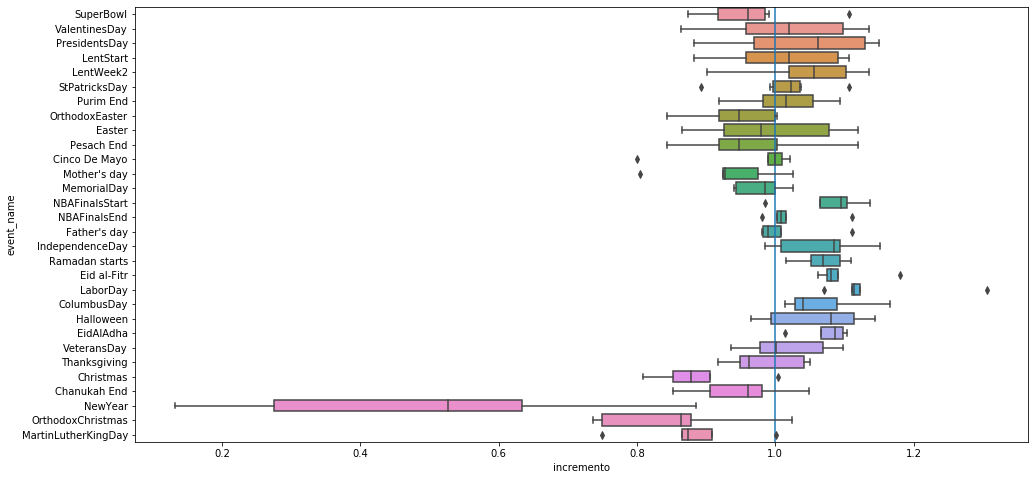

In [25]:
from matplotlib import rcParams
rcParams["figure.figsize"]=(16,8)
plt.axvline(x=1)

sns.boxplot(x="incremento", y="event_name", data=incremento_festivos[incremento_festivos["cat_id"]=="HOUSEHOLD"])

In [26]:
dias_festivos=incremento_festivos["event_name"].unique()
categorias= semana_comparasion["cat_id"].unique()
efecto_festivo=pd.DataFrame()

for puente in dias_festivos:
    for categoria in categorias:
        categoria_semana= incremento_festivos[(incremento_festivos["cat_id"]==categoria)& (incremento_festivos["event_name"]==puente)]
        promedio= categoria_semana["incremento"].mean()
        desv=categoria_semana["incremento"].std()
        numero=len(categoria_semana)
        error= desv/(numero**.5)
        prueba= vale.ttest_1samp(categoria_semana["incremento"],popmean=1.0)
        diccionario= {"categoria":categoria,"puente":puente,"promedio":promedio,"desv":desv,"muestra": numero, "error":error,"estadistico":prueba[0],"valorp":prueba[1]}
        

        
        efecto_festivo= efecto_festivo.append(pd.DataFrame(pd.Series(diccionario)).T)
        
efecto_festivo["conclusion"]= np.where(efecto_festivo["valorp"]>= .05,"sin efecto","efecto")
conclusion_final=efecto_festivo.pivot(index="puente",columns="categoria",values="conclusion")
print(conclusion_final)
        

categoria                 FOODS     HOBBIES   HOUSEHOLD
puente                                                 
Chanukah End         sin efecto  sin efecto  sin efecto
Christmas                efecto  sin efecto      efecto
Cinco De Mayo        sin efecto  sin efecto  sin efecto
ColumbusDay              efecto  sin efecto  sin efecto
Easter               sin efecto  sin efecto  sin efecto
Eid al-Fitr          sin efecto  sin efecto      efecto
EidAlAdha            sin efecto  sin efecto      efecto
Father's day         sin efecto  sin efecto  sin efecto
Halloween            sin efecto      efecto  sin efecto
IndependenceDay          efecto  sin efecto  sin efecto
LaborDay                 efecto  sin efecto      efecto
LentStart            sin efecto  sin efecto  sin efecto
LentWeek2            sin efecto  sin efecto  sin efecto
MartinLutherKingDay      efecto  sin efecto      efecto
MemorialDay              efecto  sin efecto  sin efecto
Mother's day         sin efecto  sin efecto  sin

In [27]:
#print(calendario_puente_final[calendario_puente_final["event_name"]=="Father's day"])

## ¿Existe una relación entre el comportamiento del precio promedio contra estas propias fechas festivas?

#Serie de tiempo, una por categoria, por cada categoria voy a promediar todos los articulos por semanas.
#usar lista de fechas festivas para promediar precios por categoria. en semanas festivas
#comparar el incremento
#hacer prueba de hipotesis y ver las graficas.
#revisar que tengan efecto o no.



In [28]:
#print(precio_venta)
#print(cat_art)
serie_precio= precio_venta.merge(cat_art[["item_id","cat_id"]],on="item_id")
serie_precio= serie_precio.groupby(["cat_id","wm_yr_wk"]).median().reset_index()

serie_precio["T"]=np.concatenate([np.arange(1,283),np.arange(1,283),np.arange(1,283)])
print(serie_precio)
#print((np.repeat(np.arange(1,283),3)))

        cat_id  wm_yr_wk  sell_price    T
0        FOODS     11101        2.48    1
1        FOODS     11102        2.48    2
2        FOODS     11103        2.48    3
3        FOODS     11104        2.48    4
4        FOODS     11105        2.48    5
..         ...       ...         ...  ...
841  HOUSEHOLD     11617        4.94  278
842  HOUSEHOLD     11618        4.94  279
843  HOUSEHOLD     11619        4.94  280
844  HOUSEHOLD     11620        4.94  281
845  HOUSEHOLD     11621        4.94  282

[846 rows x 4 columns]


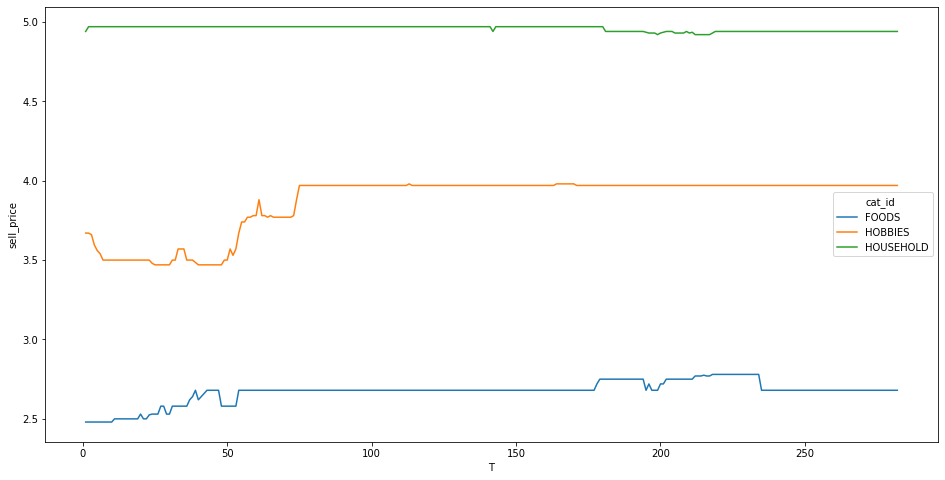

In [29]:
sns.lineplot(x="T",y="sell_price", data= serie_precio, hue="cat_id")

In [30]:
#print(calendario_puente_final)
#print(precio_venta)
precios_puente= serie_precio.merge(calendario_puente_final[["event_name","wm_yr_wk"]],on="wm_yr_wk",how="left")
precios_puente["año"]= np.floor(precios_puente["wm_yr_wk"]/100)-100
precios_año= precios_puente.groupby(["año","cat_id"])["sell_price"].mean().reset_index(name="mean_price")

precios_puente=precios_puente.merge(precios_año, on=["año","cat_id"])
precios_puente= precios_puente.dropna()
precios_puente["incremento"]=precios_puente["sell_price"]/precios_puente["mean_price"]
print(precios_puente)

        cat_id  wm_yr_wk  sell_price    T     event_name   año  mean_price  \
1        FOODS     11102        2.48    2      SuperBowl  11.0     2.55181   
2        FOODS     11103        2.48    3  ValentinesDay  11.0     2.55181   
3        FOODS     11104        2.48    4  PresidentsDay  11.0     2.55181   
5        FOODS     11106        2.48    6      LentStart  11.0     2.55181   
6        FOODS     11107        2.48    7      LentWeek2  11.0     2.55181   
..         ...       ...         ...  ...            ...   ...         ...   
910  HOUSEHOLD     11603        4.94  264  PresidentsDay  16.0     4.94000   
911  HOUSEHOLD     11603        4.94  264      LentWeek2  16.0     4.94000   
915  HOUSEHOLD     11607        4.94  268  StPatricksDay  16.0     4.94000   
916  HOUSEHOLD     11608        4.94  269      Purim End  16.0     4.94000   
917  HOUSEHOLD     11609        4.94  270         Easter  16.0     4.94000   

     incremento  
1      0.971859  
2      0.971859  
3      0.

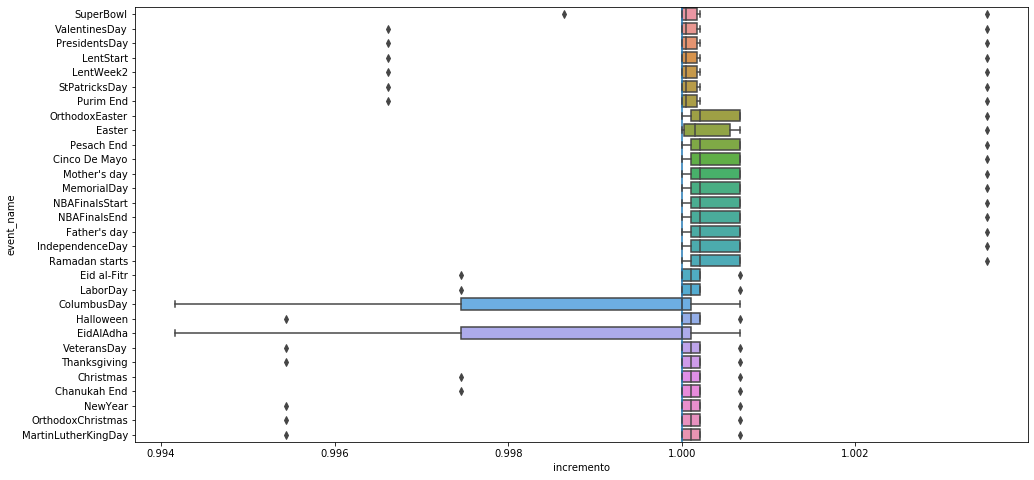

In [31]:
from matplotlib import rcParams
rcParams["figure.figsize"]=(16,8)
plt.axvline(x=1)

sns.boxplot(x="incremento", y="event_name", data=precios_puente[precios_puente["cat_id"]=="HOUSEHOLD"])

## Agrupa los datos a nivel tienda y a nivel producto. reliza el analisis a nivel departamento. para cada año saca el precio promedio  y venta promedio para cada articulo. realiza un diagrama de dispersion para comparar el precio contra la venta. calcula el coeficiente de correlacion de pearson para cada departamento; en caso de salir alta correlacion, genera una ecuacion  de que tanto decrementa la venta por cada peso que le aumenta al producto. utilizando regresion lineal. si se detecta un patron no lineal, utiliza transformaciones logatrimicas.



In [32]:
#tabla con resultado final para cada tienda, para cada articulo, por cada año  queremos venta promedio y su precio promedio. 
# una tablla que tenga articulos, tiempo(años ) y tienda.
#venta promedio semanal por año.

#print(precio_venta)
#print(ventas_trans)
tabla_art=precio_venta
tabla_art["año"]= np.floor(tabla_art["wm_yr_wk"]/100)-100
tabla_precio=tabla_art.groupby(["año","store_id","item_id"])["sell_price"].mean().reset_index()
tabla_ventas= ventas_trans.merge(calendario[["d","wm_yr_wk"]],on="d")
tabla_ventas["año"]= np.floor(tabla_ventas["wm_yr_wk"]/100)-100

tabla_ventas=tabla_ventas.groupby(["año","num_store","num_item_id","wm_yr_wk"])["sales"].sum().reset_index()
tabla_ventas=tabla_ventas.groupby(["año","num_store","num_item_id"])["sales"].mean().reset_index()
tabla_ventas=tabla_ventas.merge(cat_art[["item_id","dept_id","num_item_id"]],on="num_item_id")
tabla_ventas=tabla_ventas.merge(cat_st.drop("state_id",axis=1),on="num_store")
#print(tabla_precio)
#print(tabla_ventas)
tabla_unica=tabla_ventas.merge(tabla_precio,on=["item_id","store_id","año"]).reset_index()
tabla2=tabla_unica.groupby(["store_id","item_id","dept_id"])[["sales","sell_price"]].mean().reset_index()
tabla2["precioslog"]=np.log(tabla2["sell_price"])
tabla2["saleslog"]=np.log(tabla2["sales"])
print(tabla2)


      store_id          item_id      dept_id      sales  sell_price  \
0         CA_1      FOODS_1_001      FOODS_1   5.565735    2.176154   
1         CA_1      FOODS_1_002      FOODS_1   3.312772    8.991538   
2         CA_1      FOODS_1_003      FOODS_1   5.719158    3.002276   
3         CA_1      FOODS_1_004      FOODS_1  61.661901    1.863332   
4         CA_1      FOODS_1_005      FOODS_1   8.332608    3.355064   
...        ...              ...          ...        ...         ...   
30485     WI_3  HOUSEHOLD_2_512  HOUSEHOLD_2   2.196420    3.970000   
30486     WI_3  HOUSEHOLD_2_513  HOUSEHOLD_2   3.427794    2.780000   
30487     WI_3  HOUSEHOLD_2_514  HOUSEHOLD_2   0.748246   18.879104   
30488     WI_3  HOUSEHOLD_2_515  HOUSEHOLD_2   0.831640    1.970000   
30489     WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2   0.820392    5.940000   

       precioslog  saleslog  
0        0.777559  1.716629  
1        2.196284  1.197785  
2        1.099371  1.743822  
3        0.622366  4.121666

<class 'pandas.core.frame.DataFrame'>


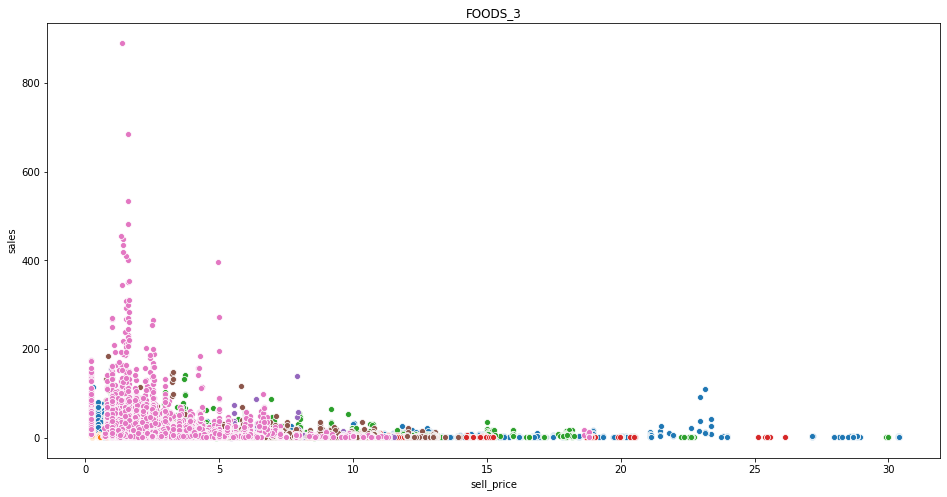

In [61]:
departamento=tabla_unica["dept_id"].unique()
data= tabla2[["precioslog","dept_id","saleslog"]]
dfregresion=[]
for dept in departamento:
    
    ax= sns.scatterplot(x="sell_price",y="sales",data=tabla2[tabla2["dept_id"]==dept])
    ax.set_title(dept)
    
    data_1=data[data["dept_id"]==dept]
    correlacion= data_1.corr()
    #print(correlacion)
   
    regresor=linear_model.LinearRegression()
    regresor.fit(data_1["precioslog"].values.reshape(-1,1),data_1["saleslog"].values.reshape(-1,1))
    beta1=regresor.coef_[0,0]
    beta0=regresor.intercept_[0]
    x=np.arange(np.exp(min(data_1["precioslog"])),np.exp(max(data_1["precioslog"])),0.01)
    y= np.exp(beta0)* x**beta1
    yprima= beta1*np.exp(beta0) * (x**(beta1-1))
    
    diccionario={"departamento":dept,"beta1":beta1,"beta0":beta0}
    regresion= pd.Series(data=diccionario)
    dfregresion.append(regresion)
    #plt.plot(x,y,color="black")
    #plt.show()

dfregresion=pd.concat(dfregresion,axis=1).T
print(dfregresion)

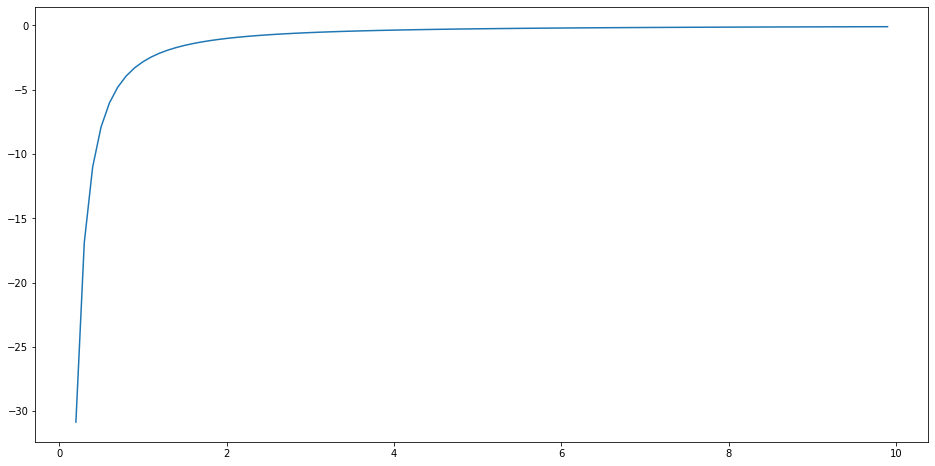

In [37]:
x=np.arange(0.2,10,0.1)
y=5.8252/x**(.4852)#estimacion cuanto vendo por unidad de precio
y=-2.8263/x**(1.4852)# tanto afecta mover el precio.
plt.plot(x,y)